In [2]:
import sqlite3
import sys
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.api as sm

sys.path.append('../')

from dotenv import load_dotenv
load_dotenv()

import os

DB_PATH = os.getenv("DB_PATH")

conn = sqlite3.connect(DB_PATH)
cursor = conn.cursor()

pd.set_option('mode.chained_assignment', None)

In [3]:
# Load and clean individuals' main information
df_individual = pd.read_sql_query("SELECT * FROM individuals_main_information", conn)
df_individual = df_individual[['individual_wikidata_id', 'birthyear']].dropna(subset=['birthyear'])
df_individual['decade'] = df_individual['birthyear'].apply(lambda x: int(x/10)*10)

# Load and clean individuals' regions
df_individual_region = pd.read_sql_query("SELECT * FROM individuals_regions", conn)
df_individual_region = df_individual_region[['individual_wikidata_id', 'region_name']].drop_duplicates()

# Load and clean identifiers meta-data
df_identifiers = pd.read_sql_query("SELECT * FROM identifiers", conn)
df_identifiers['country_name'].fillna('', inplace=True)
df_identifiers['identifier_name'] = df_identifiers.apply(lambda x: f"{x['identifier_name']} ({x['country_name']})" if x['country_name'] else x['identifier_name'], axis=1)
df_identifiers = df_identifiers.drop(['country_wikidata_id', 'count_records', 'identifier_url', 'country_name', 'identifier_name_country'], axis=1).drop_duplicates()

# Load and clean information about individuals and identifiers
df_ind_identifiers = pd.read_sql_query("SELECT * FROM individual_identifiers", conn)
df_ind_identifiers = pd.merge(df_ind_identifiers.drop('identifier_name', axis=1), df_identifiers, on='identifiers_wikidata_id', how='left')

# Clean and standardize identifier names
df_ind_identifiers['identifier_name'] = df_ind_identifiers['identifier_name'].replace('Freebase ID', 'Google Knowledge Graph ID')
df_ind_identifiers['identifiers_wikidata_id'] = df_ind_identifiers['identifiers_wikidata_id'].replace('P646', 'P2671')
df_ind_identifiers['identifier_name'] = df_ind_identifiers['identifier_name'].replace('Deutsche Biographie (GND) ID (Germany)', 'GND ID (Germany)')
df_ind_identifiers['identifiers_wikidata_id'] = df_ind_identifiers['identifiers_wikidata_id'].replace('P7902', 'P227')

# Remove unwanted objects and duplicates
df_ind_identifiers = df_ind_identifiers[~df_ind_identifiers['individual_name'].str.contains('Painter')]
df_ind_identifiers = df_ind_identifiers[~df_ind_identifiers['identifier_name'].str.contains('superceded|obsolete')]
df_ind_identifiers = df_ind_identifiers.drop_duplicates()

In [4]:
# Merge individual information with identifiers and regions
df_merged = pd.merge(pd.merge(df_individual, df_ind_identifiers, on='individual_wikidata_id'), df_individual_region, on='individual_wikidata_id')

# Prepare data for figure
df_fig = df_merged[['individual_wikidata_id', 'decade', 'identifier_name', 'region_name']].groupby(['identifier_name', 'region_name', 'decade'])['individual_wikidata_id'].count().rename("score").reset_index()

# Prepare country identifiers for merging
df_country_id = pd.read_sql_query("SELECT * FROM identifiers", conn)
df_country_id['country_name'].fillna('', inplace=True)
df_country_id['identifier_name'] = df_country_id.apply(lambda x: f"{x['identifier_name']} ({x['country_name']})" if x['country_name'] else x['identifier_name'], axis=1)
df_country_id = df_country_id[['identifier_name', 'country_name']].drop_duplicates()

# Merge country identifiers with figure data
df_fig = pd.merge(df_fig, df_country_id, on='identifier_name')

# Prepare data for 50-year decade aggregation
df_fig_fifty = df_fig.copy()
df_fig_fifty['decade'] = df_fig_fifty['decade'].apply(lambda x: round(x/50)*50)
df_fig_fifty = df_fig_fifty.groupby(['identifier_name', 'country_name', 'region_name', 'decade'])['score'].sum().reset_index()

In [5]:
df_fig_fifty.sample(10)

,identifier_name,country_name,region_name,decade,score
15964,BBC programme ID (United Kingdom),United Kingdom,Italy,1800,2
5142,Africultures person ID (France),France,Western Europe,1800,3
21891,Babelio author ID (France),France,Western Europe,450,3
7738,Angelicum ID (Italy),Italy,Germany,1100,6
185072,Pontificio Istituto di Archeologia Cristiana I...,Italy,Northern Italy,1200,3
38467,CANTIC ID (former scheme) (Spain),Spain,Arabic world,-100,1
31993,Biographical Dictionary of Fourierism ID (France),France,Southern France,1800,2
169775,Obrazi slovenskih pokrajin ID (Slovenia),Slovenia,Southwestern Europe,1750,2
249258,Ökumenisches Heiligenlexikon ID,,Germany,1550,10
154267,NYRB contributor ID (United States of America),United States of America,East Slavic,1800,1


### Plot figure

In [6]:
def make_figure(df_graph_bis, region_name, min_decade=-500, max_decade=1800, top_identifiers=5, one_id_country=False):
    # Filter the dataframe for the specified region and decade range
    df_fig = df_graph_bis[df_graph_bis['region_name'] == region_name]
    df_fig = df_fig[(df_fig['decade'] <= max_decade) & (df_fig['decade'] >= min_decade)]
    
    # If one_id_country is True, filter for unique country identifiers
    if one_id_country:
        df_fig = df_fig[df_fig['country_name'] != '']
        unique_country_ids = df_fig.groupby(['country_name', 'identifier_name'])['score'].sum().reset_index()
        unique_country_ids = unique_country_ids.sort_values(['country_name', 'score'], ascending=(False, False))
        unique_country_ids = unique_country_ids.groupby('country_name').head(1)
        top_country_ids = list(unique_country_ids['identifier_name'])
        df_fig = df_fig[df_fig['identifier_name'].isin(top_country_ids)]
    
    # Identify the top identifiers based on the sum of scores
    top_ids = df_fig.groupby('identifier_name')['score'].sum().reset_index().sort_values('score', ascending=False)
    top_ids = list(top_ids['identifier_name'][:top_identifiers])
    df_fig = df_fig[df_fig['identifier_name'].isin(top_ids)]
    
    # Calculate the mean score for each decade
    df_fig_mean = df_fig.groupby('decade')['score'].mean().reset_index()
    df_fig_mean['identifier_name'] = 'average'

    plt.figure(figsize=(9, 7))

    # Plot LOWESS regression for each top identifier with alpha
    for identifier in top_ids:
        subset = df_fig[df_fig['identifier_name'] == identifier]
        lowess = sm.nonparametric.lowess(subset['score'], subset['decade'], frac=0.15)
        plt.plot(lowess[:, 0], lowess[:, 1], label=identifier, linewidth=2, alpha=0.25)

    # Calculate and plot LOWESS for the average score without alpha
    lowess_mean = sm.nonparametric.lowess(df_fig_mean['score'], df_fig_mean['decade'], frac=0.15)
    plt.plot(lowess_mean[:, 0], lowess_mean[:, 1], label='average', linewidth=3, color='black')

    # Set the title and labels
    plt.title(region_name, fontsize=20)
    plt.xlabel('', fontsize=20)
    plt.ylabel('Log Number of CPs', fontsize=20)
    
    # Set the scale, limits, and ticks
    plt.yscale('log')
    plt.xticks(np.arange(min_decade, max_decade + 1, 500), fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlim(min_decade, max_decade)
    
    # Add the legend and grid
    plt.legend(title='', fontsize=10, title_fontsize=15)
    plt.grid(False)

    # # Save the figure.savefig(f"figures/{region_name.lower()}_identifiers.png", dpi=300)

    return df_fig


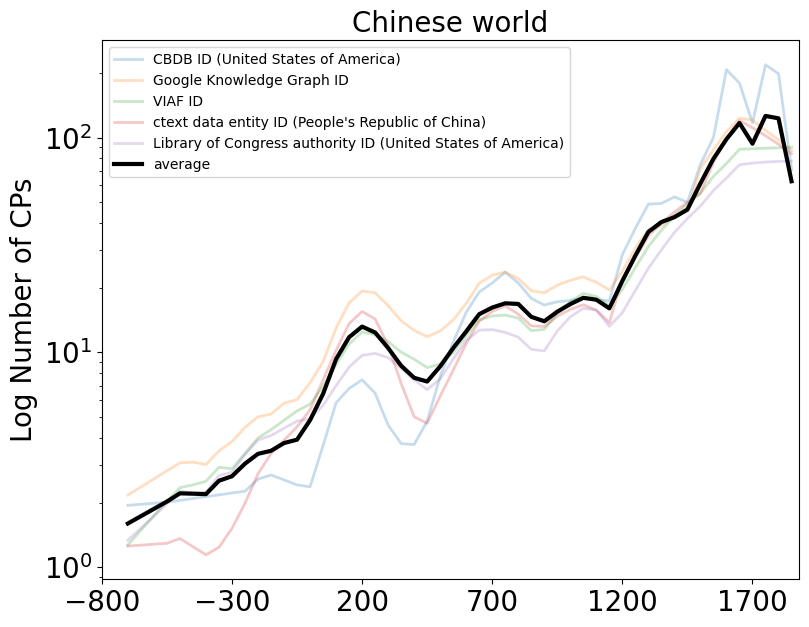

In [7]:
region_name = 'Chinese world'

df_fig_china = make_figure(df_fig_fifty,
            region_name=region_name,
            min_decade=-800,
            max_decade=1880,
            top_identifiers=5,
            one_id_country=False)

plt.show()


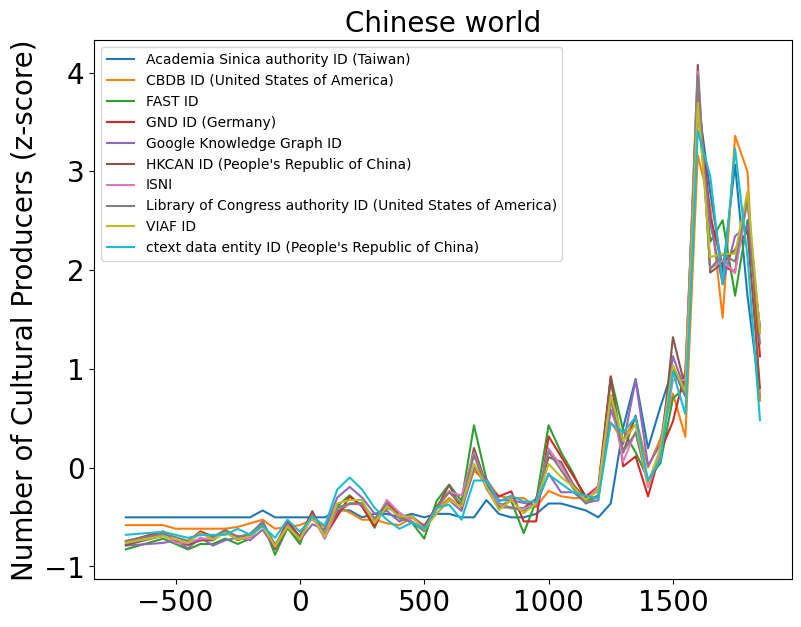

In [8]:
df_china = df_fig_fifty[df_fig_fifty['region_name']=='Chinese world']
df_china = df_china[['identifier_name', 'decade', 'score']]

top_ids = df_china.groupby('identifier_name')['score'].sum().reset_index().sort_values('score', ascending=False)
top_ids_list = list(top_ids['identifier_name'][:10])
df_china = df_china[df_china['identifier_name'].isin(top_ids_list)]

# Pivot the data for analysis, using 'decade' as index and 'identifier_name' as columns
df_pivot = df_china.pivot_table(values='score', index='decade', columns='identifier_name', fill_value=0)

from scipy.stats import zscore

# Calculate the z-scores for each identifier across the decades
zscored_df = df_pivot.apply(zscore)

# Calculate the correlation matrix for the identifiers
correlation_matrix = zscored_df.corr()

# Plotting the z-scores
plt.figure(figsize=(9, 7))
for column in zscored_df.columns:
    plt.plot(zscored_df.index, zscored_df[column], label=f'{column}')
plt.title('')
plt.xlabel('')
plt.ylabel('z-score')
plt.legend()

# Set the title and labels
plt.title(region_name, fontsize=20)
plt.xlabel('', fontsize=20)
plt.ylabel('Number of Cultural Producers (z-score)', fontsize=20)

# Set the scale, limits, and ticks
#plt.yscale('log')
plt.yticks(fontsize=20)
plt.xticks( fontsize=20)

plt.yticks(fontsize=20)

# Add the legend and grid
plt.legend(title='', fontsize=10, title_fontsize=15)
plt.grid(False)

plt.show()


In [9]:
correlation_matrix.mean().mean()

0.9715011318063833